I computed realizations of multiple HODs for a few statistics in the darksky boxes. This notebook is gonna combine them into a jackknife covmat. It'll also add some estimate of the shape noise contribution. 

In [428]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [429]:
import numpy as np
from glob import glob
from os import path

In [430]:
#shape_noise_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/shape_noise.npy')
shape_noise_covmat = np.load('./Hankel_transform/shape_noise.npy')

In [431]:
print np.sqrt(np.diag(shape_noise_covmat))

[1.0263207  0.98494148 0.90722623 0.69274081 0.57677226 0.45103709
 0.32990732 0.23736836 0.17742547 0.13398334 0.10010477 0.07595037
 0.05802125 0.04515957 0.03575584 0.02910926 0.02429026 0.02063339]


In [432]:
darksky_h = 0.7036893781978598

In [433]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat_v2/'

In [434]:
outputs = sorted(glob(path.join(output_dir, 'wp_ds_cic_darksky_obs_???_v2.npy')))
print len(outputs)

512


In [435]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5,  2*18 + 14)) # num bins and num HODs 

In [436]:
2*18+14

50

In [437]:
for i,output_file in enumerate(outputs):
    if i == 0:
        continue
    output = np.load(output_file)
    all_outputs[i] = output#.mean(axis = 0)


In [438]:
all_outputs[0] = all_outputs[1:].mean(axis = 0)

In [439]:
all_outputs.shape

(512, 5, 50)

In [440]:
# undo a little h error of mine. 
# WARNING i've since corrected this so it will no longer be necessary with new computations
all_outputs[:, :, 18:36]*=darksky_h**2

In [441]:
rp_bins = np.logspace(-1.0, 1.6, 19)
cic_bins = np.round(np.r_[np.linspace(1, 9, 8), np.round(np.logspace(1,2, 7))] )

In [442]:
cic_bins

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  15.,  22.,
        32.,  46.,  68., 100.])

In [443]:
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0
cic_points = (cic_bins[1:]+cic_bins[:-1])/2.0

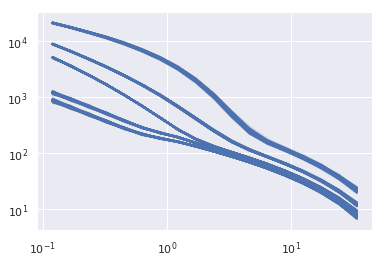

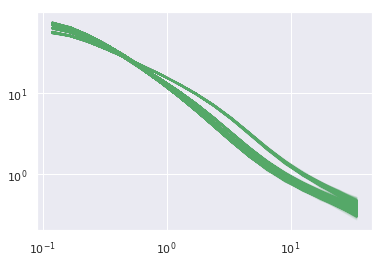

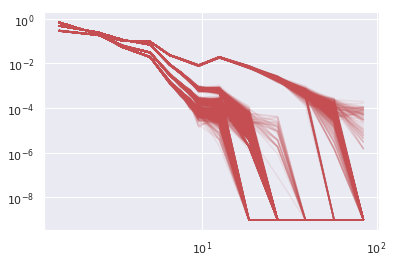

In [444]:
for hod_idx in xrange(5):
    color = 'b' 
    plt.plot(rp_points, (all_outputs[:,hod_idx, :18]).T, alpha = 0.1, color = color)
    plt.loglog();
plt.show();
for hod_idx in xrange(4):
    plt.plot(rp_points, (all_outputs[:,hod_idx, 18:36]).T, alpha = 0.1, color = 'g')
    plt.loglog();
plt.show();

for hod_idx in xrange(4):
    plt.plot(cic_points, all_outputs[:, hod_idx, 36:].T, alpha = 0.1, color = 'r')
    plt.loglog();
plt.show();

In [445]:
mean = all_outputs.mean(axis = 0)

In [446]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [454]:
np.zeros(len(cic_bins)-1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [455]:
# from my HOD mock on planck
planck_y = np.array([3.67046115e+03, 2.68587097e+03, 1.86704547e+03, 1.33957041e+03,
       9.30848932e+02, 6.45761466e+02, 4.44257796e+02, 3.02746585e+02,
       2.09074584e+02, 1.52330606e+02, 1.14548962e+02, 8.90682088e+01,
       6.94674502e+01, 5.30164183e+01, 3.92803031e+01, 2.74329581e+01,
       1.77901804e+01, 1.03439673e+01, 8.12760963e+01, 6.53112366e+01,
       5.11718897e+01, 3.92571969e+01, 2.95591990e+01, 2.18952850e+01,
       1.59647482e+01, 1.14391216e+01, 7.99808271e+00, 5.44370980e+00,
       3.61379155e+00, 2.33425032e+00, 1.55491234e+00, 1.10505031e+00,
       8.02946770e-01, 6.28019530e-01, 5.08370232e-01, 4.01059480e-01,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.              ])

In [449]:
mean = all_outputs.mean(axis = 0)
R =(all_outputs - mean)

corr = np.zeros((R.shape[2], R.shape[2]))
yerr_ratio = np.zeros((R.shape[2]))
for i in xrange(R.shape[1]):
    c= R[:,i].T.dot(R[:,i])/(N-1)
    corr += cov_to_corr(c)
    yerr_ratio += np.sqrt(np.diag(c))/mean[i]
    
    
corr/= (mean.shape[0])#*(N-1)
yerr_ratio/=(mean.shape[0])

In [452]:
print yerr_ratio

[0.02115109 0.0183483  0.01744804 0.01716035 0.01625753 0.01611677
 0.0161818  0.01663322 0.01805861 0.01930252 0.02058216 0.01986416
 0.01732619 0.01736562 0.01966843 0.02300119 0.02934295 0.04283084
 0.01391396 0.01023869 0.00805139 0.00623074 0.00519129 0.00422603
 0.00403115 0.00486841 0.00621156 0.0083079  0.01069009 0.01347838
 0.01575578 0.01895495 0.0224091  0.02887563 0.03836187 0.05257422
 0.00995335 0.01223205 0.01341301 0.01555462 0.03699359 0.05989768
 0.09231545 0.13713854 0.19617507 1.24801861 3.87076714 0.06443822
 0.16385223 0.62735347]


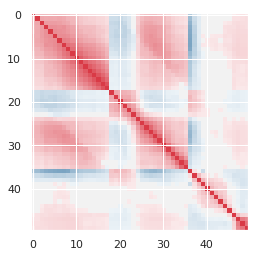

In [451]:
plt.imshow(corr, cmap = cmap, vmin=-1)

In [456]:
yerr = yerr_ratio*planck_y
cov = corr*np.outer(yerr, yerr)

In [457]:
cov.shape

(50, 50)

In [458]:
np.min(cov)

-16.227037311238956

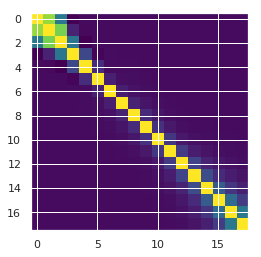

In [459]:
plt.imshow(cov_to_corr(shape_noise_covmat), cmap = 'viridis')

In [460]:
print(cov_to_corr(shape_noise_covmat))[:5, :5]

[[ 1.00000000e+00  8.42406214e-01  3.86208997e-01 -2.93016279e-02
  -1.97547565e-04]
 [ 8.42406214e-01  1.00000000e+00  7.88979947e-01  7.39946700e-02
  -3.67370677e-03]
 [ 3.86208997e-01  7.88979947e-01  1.00000000e+00  3.73641155e-01
  -2.94861577e-02]
 [-2.93016279e-02  7.39946700e-02  3.73641155e-01  1.00000000e+00
   1.92649413e-01]
 [-1.97547565e-04 -3.67370677e-03 -2.94861577e-02  1.92649413e-01
   1.00000000e+00]]


In [461]:
full_cov = deepcopy(cov)

full_cov[18:36][:, 18:36] = full_cov[18:36][:, 18:36]+ shape_noise_covmat

In [462]:
corr = cov_to_corr(cov)
full_corr = cov_to_corr(full_cov)

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


In [463]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

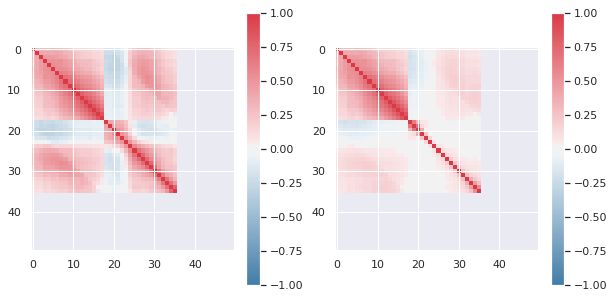

In [464]:
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
im = plt.imshow(corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(122)
im = plt.imshow(full_corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

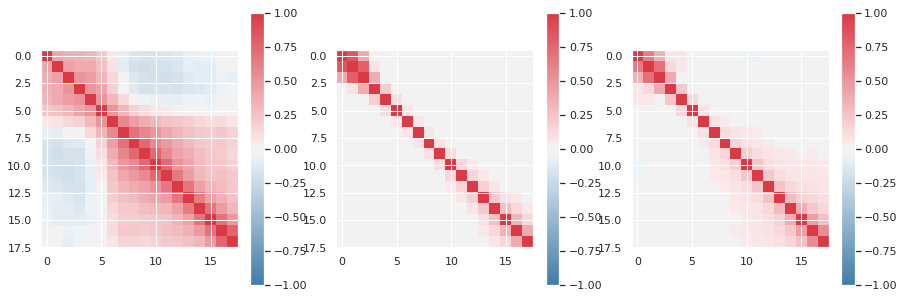

In [465]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
im = plt.imshow(corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(132)
im = plt.imshow(cov_to_corr(shape_noise_covmat), cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(133)
im = plt.imshow(full_corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

In [466]:
np.sqrt(np.diag(full_corr)[18:36])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

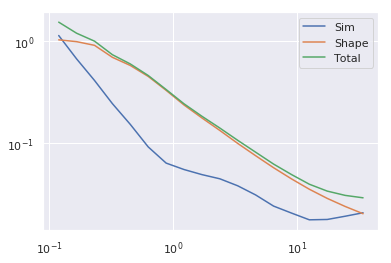

In [467]:
plt.plot(rp_points, np.sqrt(np.diag(cov)[18:36]), label = 'Sim')
plt.plot(rp_points,np.sqrt(np.diag(shape_noise_covmat)), label = 'Shape')

plt.plot(rp_points,np.sqrt(np.diag(full_cov)[18:36]), label = 'Total')
#plt.xscale('log')
plt.loglog();
plt.legend(loc = 'best')

In [468]:
print full_corr[30:30+5][:, 30:30+5]

[[1.         0.25777658 0.13207603 0.09760899 0.0852919 ]
 [0.25777658 1.         0.29435698 0.17003437 0.12638582]
 [0.13207603 0.29435698 1.         0.36671018 0.21836128]
 [0.09760899 0.17003437 0.36671018 1.         0.447718  ]
 [0.0852919  0.12638582 0.21836128 0.447718   1.        ]]


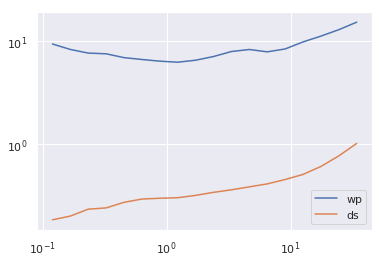

In [469]:
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[:18, :18]) ), label = 'wp')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[18:36, 18:36]) ), label = 'ds')

plt.loglog()
plt.legend(loc='best')

In [470]:
print np.sqrt(np.diag(full_cov[:36][:,:36]))

[7.76342651e+01 4.92811538e+01 3.25762794e+01 2.29874934e+01
 1.51333047e+01 1.04075886e+01 7.18888869e+00 5.03565087e+00
 3.77559541e+00 2.94036425e+00 2.35766475e+00 1.76926487e+00
 1.20360634e+00 9.20662808e-01 7.72582034e-01 6.30990729e-01
 5.22016402e-01 4.43040771e-01 1.52715641e+00 1.19049197e+00
 9.96397312e-01 7.34656111e-01 5.96836050e-01 4.60430543e-01
 3.36125829e-01 2.43813755e-01 1.84249699e-01 1.41410422e-01
 1.07300410e-01 8.22089453e-02 6.29814218e-02 4.97808088e-02
 4.00279814e-02 3.42958831e-02 3.11503736e-02 2.95013596e-02]


In [471]:
print  np.sqrt(np.diag(full_cov[18:36, 18:36]) )

[1.52715641 1.19049197 0.99639731 0.73465611 0.59683605 0.46043054
 0.33612583 0.24381375 0.1842497  0.14141042 0.10730041 0.08220895
 0.06298142 0.04978081 0.04002798 0.03429588 0.03115037 0.02950136]


In [472]:
#emu covs
emu_cov_fnames = ['/home/users/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov_lpw.npy',
                  '/home/users/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov_lpw.npy']

In [473]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [474]:
emu_corr = cov_to_corr(emu_cov)

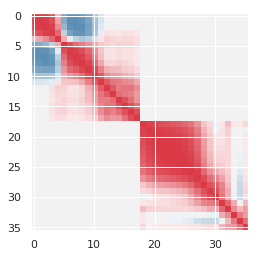

In [475]:
plt.imshow(emu_corr, cmap = cmap, vmin = -1)

In [476]:
full_emu_cov = full_cov[:36][:, :36] + emu_cov

In [477]:
print np.sqrt(np.diag(full_emu_cov[:36][:,:36]))

[1.37669575e+03 7.33650489e+02 3.25703541e+02 1.35519223e+02
 5.01600613e+01 3.80618785e+01 3.72681171e+01 2.61867059e+01
 1.38745147e+01 6.64538214e+00 3.56569118e+00 2.24686736e+00
 1.54070027e+00 1.22683892e+00 1.01436533e+00 8.51484037e-01
 7.23835854e-01 6.46931554e-01 1.86584397e+00 1.60696572e+00
 1.46657905e+00 1.22288537e+00 1.02680179e+00 8.10289696e-01
 5.87980552e-01 3.95821571e-01 2.59597555e-01 1.72164003e-01
 1.21259045e-01 9.08675323e-02 6.81930040e-02 5.32192586e-02
 4.30411300e-02 3.62116965e-02 3.39057799e-02 3.26984810e-02]


In [478]:
full_emu_corr = cov_to_corr(full_emu_cov)

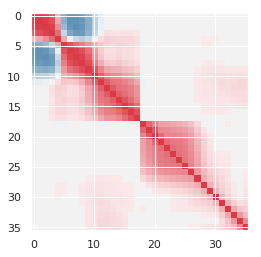

In [479]:
plt.imshow(full_emu_corr, cmap = cmap, vmin = -1)

In [480]:
mean[:,:18].mean(axis=0)

array([7407.57577016, 5860.73332887, 4562.57221101, 3528.4855154 ,
       2653.86635206, 1942.18765577, 1375.70010706,  920.94666884,
        574.1329663 ,  334.4338443 ,  189.53636194,  118.15514169,
         84.2912142 ,   62.74489775,   45.52641089,   31.41342237,
         20.19772416,   11.76164792])

In [481]:
np.sqrt(np.diag(full_emu_cov[:18, :18]) )/mean[:-1, :18].mean(axis=0)

array([0.34409575, 0.24878065, 0.15354179, 0.08983655, 0.04798511,
       0.05336156, 0.07710914, 0.08067577, 0.06307723, 0.04314802,
       0.03165717, 0.02620375, 0.02342762, 0.02479873, 0.02824135,
       0.03436781, 0.04549713, 0.07038603])

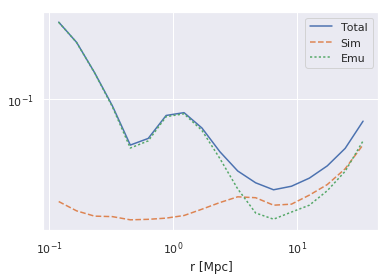

In [482]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) )/mean[:-1, :18].mean(axis=0), label = 'Total')
plt.plot(rp_points, np.sqrt(np.diag(cov[:18, :18]) )/mean[:-1, :18].mean(axis=0), ls = '--', label = 'Sim')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) )/mean[:-1, :18].mean(axis=0), ls = ':', label = 'Emu')


#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
#plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'ds', color ='r')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'r', ls = '--')
#plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'r',  ls = '-.')

#plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

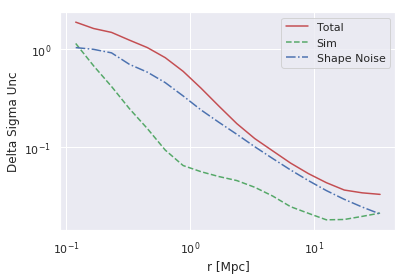

In [483]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'Total', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'g', label = 'Sim', ls = '--')
#plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'b', label = 'Shape Noise',ls = '-.')

plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

In [484]:
0.7**2

0.48999999999999994